# NLP Milestone Project - Skimlit 🔥 🔥

In [1]:
# Import necessary libs
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, Model, activations, optimizers, losses


# Get Data

In [2]:
# Clone the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 21.83 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Start our experiment with 20K dataset with number replaced by "@"
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocess data


In [6]:
# Create a function to get the text data from a document
def get_lines(filename):
  '''
  Read filename and returns the lines of text as a list.

  Args:
    filename (str) : File path

  Returns:
    A list of strings with one string per line from target filename.
  '''
  with open(filename, 'r') as f:
    return f.readlines()

In [7]:
# Let's read in training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev another name for validation
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(test_samples), len(val_samples))



180040 30135 30212
CPU times: user 396 ms, sys: 76.1 ms, total: 472 ms
Wall time: 474 ms


In [11]:
# Check the first abstract of training_data
train_samples[:13]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [12]:
# Visualize the data
# Data is in dictionary so convert to dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [13]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of the labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

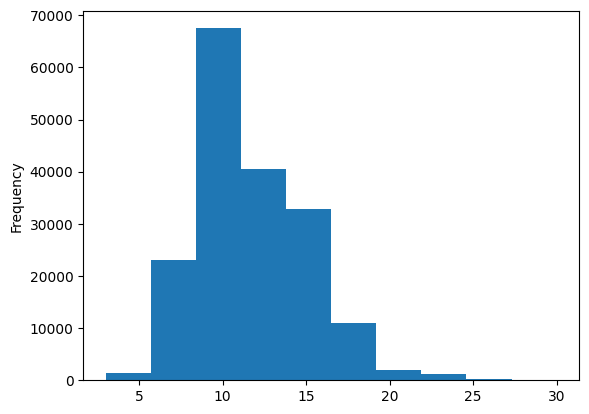

In [15]:
# Lets check length of different lines
train_df.total_lines.plot.hist()

# Get list of sentences


In [16]:
# Convert abstract text lines to lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [17]:
len(train_sentences)

180040

In [18]:
# View first 10 training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numerical lables

In [19]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
# check what labels looks like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

## Label Encode

In [21]:
# Extract labels (traget columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [22]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# Get class names and number of classes from label encoded instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Starting the modelling experiments

# Model 0 : Getting a baseline

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [25]:
# Create model
model_0 = Pipeline([
    ("tf_idf", TfidfVectorizer()),
    ("clf",  MultinomialNB())
])

# Fit the pipeline
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate the model
model_0.score(X= val_sentences,
              y = val_labels_encoded)

0.7218323844829869

In [27]:
# Make prediction using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
##
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-24 15:51:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-24 15:51:37 (46.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [29]:
# Import calculate_results helper function
from helper_functions import calculate_results


In [30]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing the text for deep sequences model

In [31]:
# How long each sentence is on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

# Calculating the mean as we need to make each sentence of equal length
# by padding the shorter sentences and cutting down the lengthier senteces

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

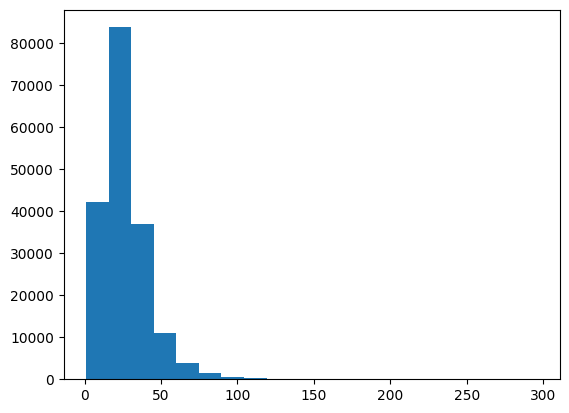

In [32]:
# whats the distribution
plt.hist(sent_lens, bins=20)

In [33]:
# How long of sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [34]:
#Max seq length in training set
max(sent_lens)

296

## Create text vectorizer layer  


In [35]:
## How many words in our vocab
max_tokens = 68000


In [36]:
# Create text vectorizer
text_vectorizer = layers.TextVectorization(max_tokens = max_tokens,
                                           output_sequence_length = output_seq_len)

In [37]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [38]:
# test out text vectorizer on random sentences
target_sentence = random.choice(train_sentences)
target_sentence

'in the conventional needling group , the acupoint selection and needling method were used routinely .'

In [39]:
print(f"Text:\n{target_sentence} ")
print(f"Length:\n {len(target_sentence.split())}")
print(f"Vectorized Sentence:\n {text_vectorizer([target_sentence])}")

Text:
in the conventional needling group , the acupoint selection and needling method were used routinely . 
Length:
 16
Vectorized Sentence:
 [[   5    2  366 2233   13    2 2434 2171    3 2233  363    9   98 3839
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [40]:
# How many words in our vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most COmmon words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most COmmon words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
# get the config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create Custome Embedding layer

In [42]:
# Create token embedding layers
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero= True, # Use 0 to mask variable sequence length
                               name = "token_embedding",

                               )

In [43]:
# show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])

print(f"Token Vectorized Sentence:\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}")
print(f"Shape:\n{embedded_sentence.shape}")


Sentence before vectorization:
in the conventional needling group , the acupoint selection and needling method were used routinely .

Token Vectorized Sentence:
 [[   5    2  366 2233   13    2 2434 2171    3 2233  363    9   98 3839
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.03627292 -0.03117704 -0.01214361 ... -0.04922926  0.04545549
    0.00040901]
  [ 0.00017686  0.03255493 -0.02358819 ... -0.0090446   0.00324465
   -0.02150147]
  [ 0.0006761  -0.00061496 -0.01774419 ... -0.00103515  0.01666737
   -0.04206134]
  ...
  [ 0.02703276 -0.02193068  0.00563004 ...  0.04537472  0.03332447
    0.00202892]
  [ 0.02703276 -0.02193068  0.00563004 ...  0.04537472  0.03332447
    0.00202892]
  [ 0.02703276 -0.02193068  0.00563004 ...  0.04537472  0.03332447
    0.00202892]]]
Shape:
(1, 55, 128)


## Creating datasets
To make sure data loads as fast as possible

In [44]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [45]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [46]:
# Take the TensorSlices dataset and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [47]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1 : CNN with Token Embeddings

In [48]:
# Create 1D conv model
inputs = layers.Input(shape=(1, ), dtype=tf.string)
text_vectors = text_vectorizer(inputs) #text to input
token_embeddings = token_embed(text_vectors)

x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss= "categorical_crossentropy",
                optimizer =tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



In [49]:
# Summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [50]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps =int(0.1 * len(valid_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 21s 31ms/step - loss: 0.9072 - accuracy: 0.6435 - val_loss: 0.6785 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6579 - accuracy: 0.7544 - val_loss: 0.6296 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6225 - accuracy: 0.7705 - val_loss: 0.5998 - val_accuracy: 0.7829


In [51]:
# Evaluate on Valid Dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6045 - accuracy: 0.7822


[0.6044970154762268, 0.7822057604789734]

In [52]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[3.9040354e-01, 2.1139048e-01, 9.8405741e-02, 2.6749611e-01,
        3.2304179e-02],
       [4.9934778e-01, 2.3060757e-01, 1.2593393e-02, 2.5109866e-01,
        6.3526486e-03],
       [1.4705491e-01, 6.8113892e-03, 1.7628378e-03, 8.4433877e-01,
        3.2098866e-05],
       ...,
       [1.8278124e-06, 6.5470493e-04, 8.0915197e-04, 2.7622896e-06,
        9.9853158e-01],
       [6.3637316e-02, 4.6324351e-01, 1.0944862e-01, 7.2716601e-02,
        2.9095393e-01],
       [1.6217829e-01, 6.7782867e-01, 3.8910814e-02, 3.3940937e-02,
        8.7141238e-02]], dtype=float32)

In [53]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [54]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.22057460611677,
 'precision': 0.778789628825636,
 'recall': 0.7822057460611678,
 'f1': 0.7796838397898386}

# Model 2 : Feature Extractor

In [55]:
# Download Pretrained Tensorflow Hub Model USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder"
                                        )

In [56]:
# Test on random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}")

use_embedding_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:{use_embedding_sentence[0][:30]}\n")
print(f"Length of embedding:\n{use_embedding_sentence.shape}")


Random Sentence:
 the neuromuscular block was monitored with acceleromyography using tof stimuli .
Sentence after embedding:[-0.00853944  0.07390872 -0.02537657 -0.08632874 -0.03679758  0.04832683
 -0.04822186 -0.01484768 -0.0409351   0.07836916  0.07676291  0.03832217
  0.06305707  0.05330166 -0.03729564 -0.03260986 -0.02044943  0.0623785
  0.01619076  0.06710967 -0.0901257   0.00091174 -0.04283771 -0.04369969
  0.03140169  0.02849295 -0.03555266  0.04789303 -0.05592855  0.02691776]

Length of embedding:
(1, 512)


In [57]:
## buidling and fitting NLP model from Tensorflow Hub
inputs = layers.Input(shape=[], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # 512 dimensional embedding vector
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_use_pretrained")


# Compile
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics= ['accuracy']
                )


In [58]:
model_2.summary()

Model: "model_2_use_pretrained"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [59]:
# Fit model 2
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9179 - accuracy: 0.6506 - val_loss: 0.7959 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7672 - accuracy: 0.7025 - val_loss: 0.7513 - val_accuracy: 0.7068
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7480 - accuracy: 0.7142 - val_loss: 0.7342 - val_accuracy: 0.7144


In [60]:
# Evaluate on valid data
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7375 - accuracy: 0.7159


[0.7374811172485352, 0.7158744931221008]

In [61]:
# Predict on data
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[0.41807753, 0.3673484 , 0.00277467, 0.20412068, 0.0076787 ],
       [0.3189781 , 0.4990947 , 0.005035  , 0.17379284, 0.0030994 ],
       [0.23521225, 0.13959262, 0.02242137, 0.5632922 , 0.03948159],
       ...,
       [0.0018855 , 0.00656668, 0.0547827 , 0.0009667 , 0.93579835],
       [0.003817  , 0.04774566, 0.19631521, 0.00141514, 0.75070703],
       [0.18655223, 0.2619905 , 0.4825348 , 0.00732404, 0.06159851]],
      dtype=float32)

In [62]:
# convert the prediction probs found with feature extraction
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [63]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.58744869588243,
 'precision': 0.7164329666793787,
 'recall': 0.7158744869588243,
 'f1': 0.7130064489552826}

#  Model 3 : Character Embeddings

In [64]:
## creating character level embedding
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [65]:
# Make function to split words to characters
def split_chars(text):
  return " ".join(list(text))

In [66]:
" ".join(list(train_sentences[1]))

'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .'

In [67]:
# Text splitting non-character level sequence into characters\
split_chars(random_train_sentence)

't h e   n e u r o m u s c u l a r   b l o c k   w a s   m o n i t o r e d   w i t h   a c c e l e r o m y o g r a p h y   u s i n g   t o f   s t i m u l i   .'

In [68]:
# Split sequence level splits into character level splist
train_chars  =[ split_chars(sentence) for sentence in train_sentences]
train_chars[:4]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [69]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence)for sentence in test_sentences]

In [70]:
# what is ideal  character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.24736e+05, 5.17520e+04, 3.22000e+03, 2.71000e+02, 4.60000e+01,
        1.00000e+01, 4.00000e+00, 1.00000e+00]),
 array([1.000000e+00, 1.741250e+02, 3.472500e+02, 5.203750e+02,
        6.935000e+02, 8.666250e+02, 1.039750e+03, 1.212875e+03,
        1.386000e+03]),
 <BarContainer object of 8 artists>)

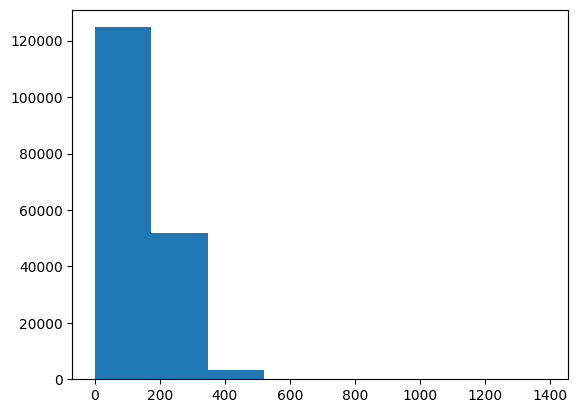

In [71]:
# Check the distribution of seuences at character
plt.hist(char_lens, bins=8)

In [72]:
# Find what character length covers 95%
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [73]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [74]:
# Create char level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and OOV token (out of vocab token)
char_vectorizer = layers.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer",
                                    standardize='lower_and_strip_punctuation'
                                    )

In [75]:
# Adapt character vectorizer to training vectors
char_vectorizer.adapt(train_chars)

In [76]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"\nNumber of different characters in character vocab:\n{len(char_vocab)}\n")
print(f"5 most common character:\n {char_vocab[:5]}")
print(f"5 least common characters:\n{char_vocab[-5:]}")


Number of different characters in character vocab:
28

5 most common character:
 ['', '[UNK]', 'e', 't', 'i']
5 least common characters:
['k', 'x', 'z', 'q', 'j']


In [77]:
# Test character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")

vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorize chars: \n{vectorized_chars}")
print(f"Vectorized Chars Length:\n{len(vectorized_chars[0])}")

Charified text:
 l a c t a t e   c l e a r a n c e   r a t e   i n   m o d i f i e d   s u r v i v i n g   s e p s i s   b u n d l e   g r o u p   w a s   s i g n i f i c a n t l y   h i g h e r   t h a n   t h a t   o f   s t a n d a r d   s u r v i v i n g   s e p s i s   b u n d l e   g r o u p   - l s b -   @   h o u r s   :   (   @   )   %   v s .   (   @   )   %   ,   t   =   - @   ,   p   =   @   ;   @   h o u r s   :   (   @   )   %   v s .   (   @   )   %   ,   t   =   - @   ,   p   =   @   ;   @   h o u r s   :   (   @   )   %   v s .   (   @   )   %   ,   t   =   - @   ,   p   =   @   - r s b -   .
Length of random_train_chars: 216
Vectorize chars: 
[[12  5 11  3  5  3  2 11 12  2  5  8  5  6 11  2  8  5  3  2  4  6 15  7
  10  4 17  4  2 10  9 16  8 21  4 21  4  6 18  9  2 14  9  4  9 22 16  6
  10 12  2 18  8  7 16 14 20  5  9  9  4 18  6  4 17  4 11  5  6  3 12 19
  13  4 18 13  2  8  3 13  5  6  3 13  5  3  7 17  9  3  5  6 10  5  8 10
   9 16  8 21  4 21  4  6 18  9  2 

## Character Level Embedding

In [78]:
# create embedding layer
char_embed = layers.Embedding(input_dim =  len(char_vocab), # Number of different characters, length of vocab
                              output_dim = 25,
                              mask_zero = True,
                              name = "char_embedding"
                              )



In [79]:
# Test embedding layers
print(f"Charified text:\n{random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded Chars:\n{char_embed_example}")
print(f"Char Embed Shape:\n{char_embed_example.shape}")

Charified text:
l a c t a t e   c l e a r a n c e   r a t e   i n   m o d i f i e d   s u r v i v i n g   s e p s i s   b u n d l e   g r o u p   w a s   s i g n i f i c a n t l y   h i g h e r   t h a n   t h a t   o f   s t a n d a r d   s u r v i v i n g   s e p s i s   b u n d l e   g r o u p   - l s b -   @   h o u r s   :   (   @   )   %   v s .   (   @   )   %   ,   t   =   - @   ,   p   =   @   ;   @   h o u r s   :   (   @   )   %   v s .   (   @   )   %   ,   t   =   - @   ,   p   =   @   ;   @   h o u r s   :   (   @   )   %   v s .   (   @   )   %   ,   t   =   - @   ,   p   =   @   - r s b -   .
Embedded Chars:
[[[ 0.01501754 -0.00074977 -0.00061016 ... -0.01505804 -0.03092989
    0.00595722]
  [ 0.01662194 -0.04036202  0.00218574 ... -0.0423173   0.03559604
   -0.01383559]
  [ 0.02528126  0.02515728  0.00304531 ... -0.00487535 -0.04478849
   -0.04843576]
  ...
  [-0.03079304  0.01237249 -0.02390206 ...  0.01504669 -0.02228459
   -0.04935163]
  [-0.03079304  0.01237249 -0.

In [80]:
## Create model
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, activation="relu", padding="same")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="Model_3_conv1D_Character_embed")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy']
                )
model_3.summary()

Model: "Model_3_conv1D_Character_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [81]:
#creare char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [82]:
# Fit the model
history_mode_3 = model_3.fit(train_char_dataset,
                             epochs =3,
                             steps_per_epoch = int(0.1 * len(train_char_dataset)),
                             validation_data = val_char_dataset,
                             validation_steps = int(0.1 * len(val_char_dataset))
                             )

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2698 - accuracy: 0.4912 - val_loss: 1.0348 - val_accuracy: 0.6007
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9999 - accuracy: 0.5973 - val_loss: 0.9396 - val_accuracy: 0.6297
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9246 - accuracy: 0.6400 - val_loss: 0.8661 - val_accuracy: 0.6679


In [83]:
#Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8852 - accuracy: 0.6580


[0.8851956725120544, 0.6579836010932922]

In [84]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.17850141, 0.47198212, 0.09878883, 0.2184602 , 0.03226744],
       [0.17358078, 0.4146165 , 0.10055263, 0.07433572, 0.23691434],
       [0.07025137, 0.2711071 , 0.3152491 , 0.19705726, 0.14633514],
       ...,
       [0.0241911 , 0.03415138, 0.11143624, 0.0173992 , 0.81282204],
       [0.053139  , 0.08975874, 0.29768765, 0.05132369, 0.5080909 ],
       [0.4660663 , 0.27380195, 0.16768043, 0.082998  , 0.00945331]],
      dtype=float32)

In [85]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [86]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.79835826823779,
 'precision': 0.6540075999921847,
 'recall': 0.6579835826823779,
 'f1': 0.6486805908922361}

In [87]:
## Create model
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Bidirectional(layers.LSTM(64,  return_sequences=True))(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3_lstm = tf.keras.Model(inputs, outputs, name="Model_3_conv1D_Character_embed")

# Compile model
model_3_lstm.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy']
                )
model_3_lstm.summary()

history_mode_3_lstm = model_3_lstm.fit(train_char_dataset,
                             epochs =3,
                             steps_per_epoch = int(0.1 * len(train_char_dataset)),
                             validation_data = val_char_dataset,
                             validation_steps = int(0.1 * len(val_char_dataset))
                             )

Model: "Model_3_conv1D_Character_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 bidirectional (Bidirection  (None, 290, 128)          46080     
 al)                                                             
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                    

# Model 4 : Combining Pretrained token  and character embeddings

In [88]:
# 1. Setup token / inputs model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char/inputs model
char_input = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_input)
char_embeddings = char_embed(char_vectors)
char_bi_lstms = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_input,
                            outputs = char_bi_lstms)

# 3. Concatenate token and char input
token_char_concat = layers.Concatenate(name="token_char_hubrid")([token_model.output, char_model.output])

# 4. Create output layers adding in dropouts
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with chart and token inputs
model_4 = tf.keras.Model(inputs= [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_hybrid")


In [89]:
model_4.summary()

Model: "model_4_hybrid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][

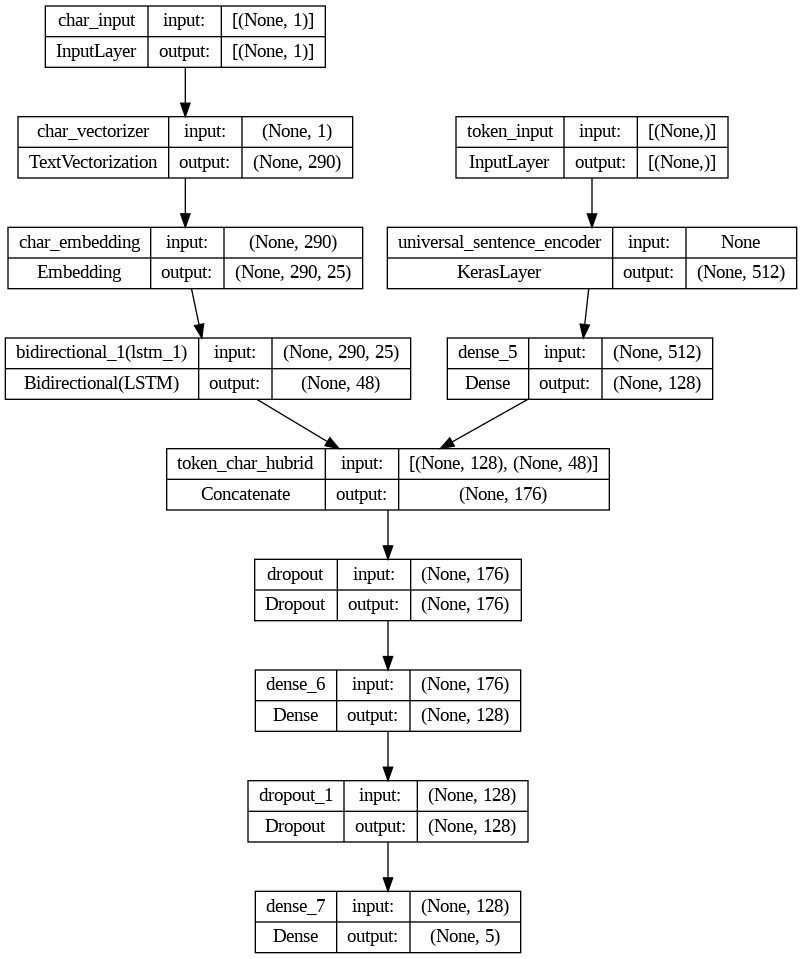

In [90]:
from keras.utils import plot_model
plot_model(model_4, show_shapes=True, show_layer_names=True)

In [91]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [92]:
# Combining token and character data into a tf.data dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# prefetch and batch data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [93]:
# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [94]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [95]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 56ms/step - loss: 0.9870 - accuracy: 0.6043 - val_loss: 0.7705 - val_accuracy: 0.7038
Epoch 2/3
562/562 [==============================] - 31s 55ms/step - loss: 0.8043 - accuracy: 0.6900 - val_loss: 0.7095 - val_accuracy: 0.7334
Epoch 3/3
562/562 [==============================] - 29s 51ms/step - loss: 0.7773 - accuracy: 0.7059 - val_loss: 0.6915 - val_accuracy: 0.7387


In [96]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6949 - accuracy: 0.7353


[0.6948562264442444, 0.7352707386016846]

In [97]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 23s 21ms/step


array([[4.52564895e-01, 3.45786750e-01, 3.82637209e-03, 1.91361293e-01,
        6.46070251e-03],
       [2.88198948e-01, 6.08065128e-01, 3.81701207e-03, 9.71521959e-02,
        2.76678056e-03],
       [2.57223636e-01, 1.24168046e-01, 4.04718593e-02, 5.58061481e-01,
        2.00750735e-02],
       ...,
       [6.81983773e-04, 8.00427049e-03, 5.67384623e-02, 1.95488363e-04,
        9.34379816e-01],
       [7.64960563e-03, 6.17352277e-02, 2.28867739e-01, 3.07172164e-03,
        6.98675692e-01],
       [2.10405946e-01, 4.45862502e-01, 2.63944060e-01, 2.30764877e-02,
        5.67110106e-02]], dtype=float32)

In [98]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [99]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.52707533430424,
 'precision': 0.7352330795065692,
 'recall': 0.7352707533430425,
 'f1': 0.7316312972857381}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

## Create positional encodings

In [100]:
# How many different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

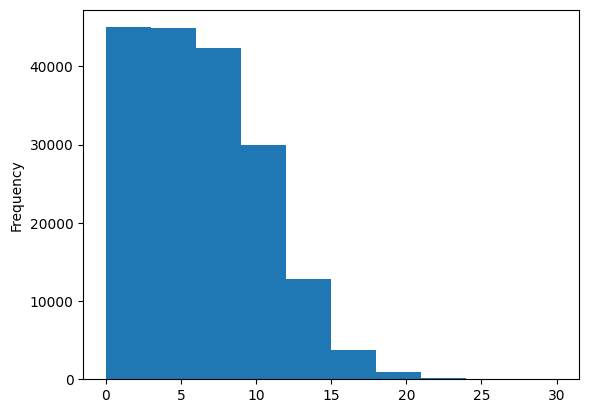

In [101]:
# Check distribution of line_number columns
train_df.line_number.plot.hist()

In [112]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [102]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

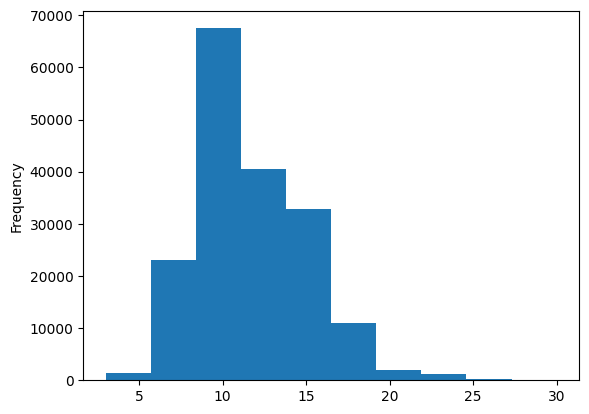

In [103]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [104]:

# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [105]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [106]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)


In [107]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

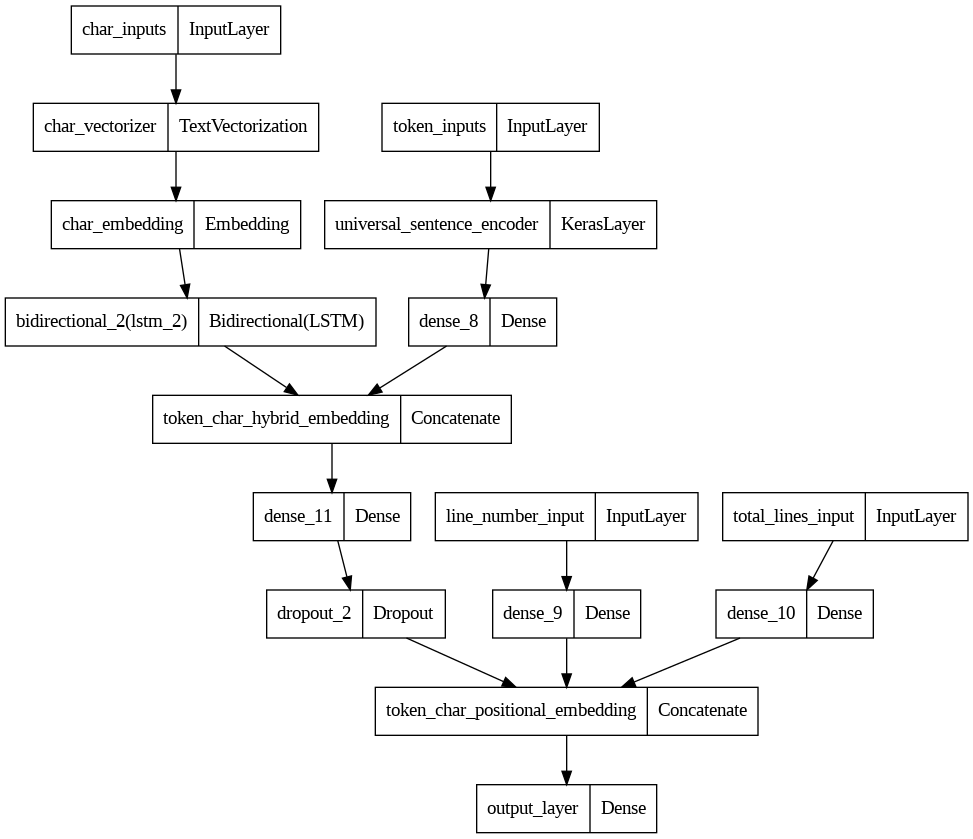

In [108]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [109]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7b7adf94bfa0> True
<keras.src.engine.input_layer.InputLayer object at 0x7b7add231f30> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7b7ad43da080> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7b7ad672a590> False
<keras.src.layers.core.embedding.Embedding object at 0x7b7a4c16b190> True
<keras.src.layers.core.dense.Dense object at 0x7b7add233880> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7b7add0eff10> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7b7adc3dc6a0> True
<keras.src.engine.input_layer.InputLayer object at 0x7b7adc49a170> True
<keras.src.engine.input_layer.InputLayer object at 0x7b7a445be4d0> True
<keras.src.layers.core.dense.Dense object at 0x7b7adc4b25f0> True
<keras.src.layers.core.dense.Dense object at 0x7b7add232950> True
<keras.src.layers.core.dense.Dense object at 0x7b7add12d390> True
<keras.src.layers.regularization.dropout.

In [110]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [113]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [120]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=30,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/30
562/562 [==============================] - 32s 57ms/step - loss: 0.9111 - accuracy: 0.8513 - val_loss: 0.9032 - val_accuracy: 0.8527
Epoch 2/30
562/562 [==============================] - 27s 48ms/step - loss: 0.8987 - accuracy: 0.8620 - val_loss: 0.9008 - val_accuracy: 0.8584
Epoch 3/30
562/562 [==============================] - 27s 47ms/step - loss: 0.8982 - accuracy: 0.8597 - val_loss: 0.9068 - val_accuracy: 0.8541
Epoch 4/30
562/562 [==============================] - 30s 54ms/step - loss: 0.9004 - accuracy: 0.8598 - val_loss: 0.9058 - val_accuracy: 0.8447
Epoch 5/30
562/562 [==============================] - 30s 53ms/step - loss: 0.9044 - accuracy: 0.8596 - val_loss: 0.9013 - val_accuracy: 0.8527
Epoch 6/30
562/562 [==============================] - 26s 46ms/step - loss: 0.9110 - accuracy: 0.8501 - val_loss: 0.9000 - val_accuracy: 0.8551
Epoch 7/30
562/562 [==============================] - 29s 52ms/step - loss: 0.9018 - accuracy: 0.8603 - val_loss: 0.9071 - val_accuracy:

562/562 [==============================] - 2s 4ms/step - loss: 0.9195 - accuracy: 0.8650 - val_loss: 0.9045 - val_accuracy: 0.8491


In [115]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 23s 20ms/step


array([[0.5012453 , 0.11650074, 0.01004305, 0.35790238, 0.01430847],
       [0.5079223 , 0.11183283, 0.06273147, 0.30376947, 0.01374395],
       [0.29488543, 0.12126085, 0.12951533, 0.395372  , 0.05896632],
       ...,
       [0.03791144, 0.12759753, 0.04785462, 0.0354938 , 0.7511427 ],
       [0.03106336, 0.34949985, 0.06977953, 0.02646418, 0.52319306],
       [0.2517448 , 0.5779532 , 0.08588743, 0.03975964, 0.04465494]],
      dtype=float32)

In [116]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [117]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.43373493975903,
 'precision': 0.8334947062522051,
 'recall': 0.8343373493975904,
 'f1': 0.8335646040463139}

In [118]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.220575,0.778790,0.782206,0.779684
pretrained_token_embed,71.587449,0.716433,0.715874,0.713006
custom_char_embed_conv1d,65.798358,0.654008,0.657984,0.648681
hybrid_char_token_embed,73.527075,0.735233,0.735271,0.731631
tribrid_pos_char_token_embed,83.433735,0.833495,0.834337,0.833565


In [121]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

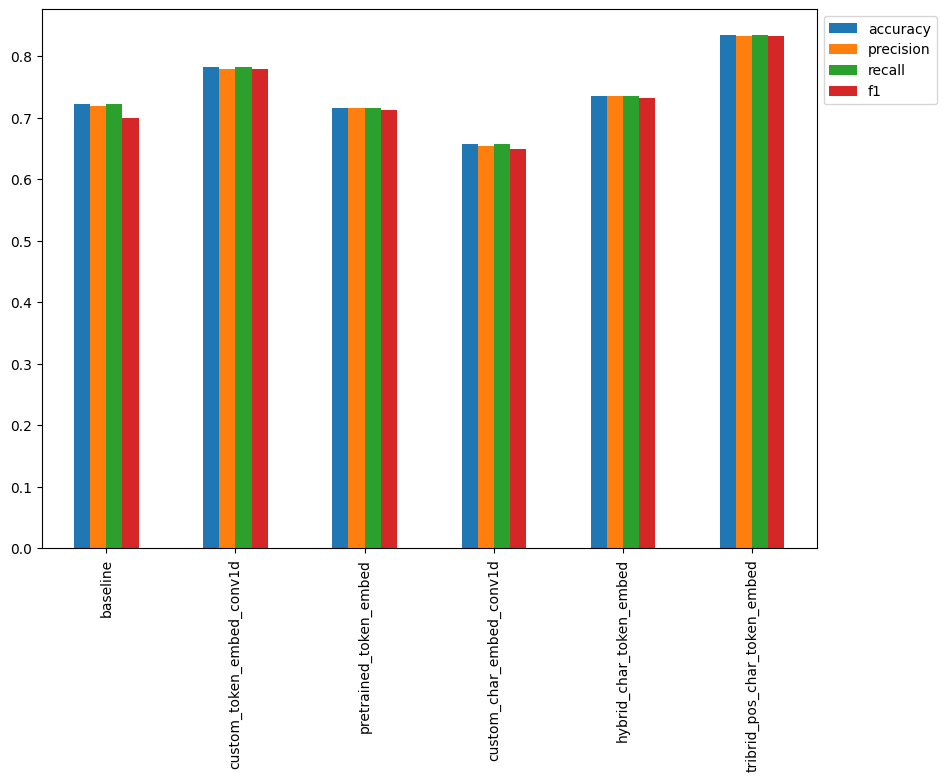

In [122]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

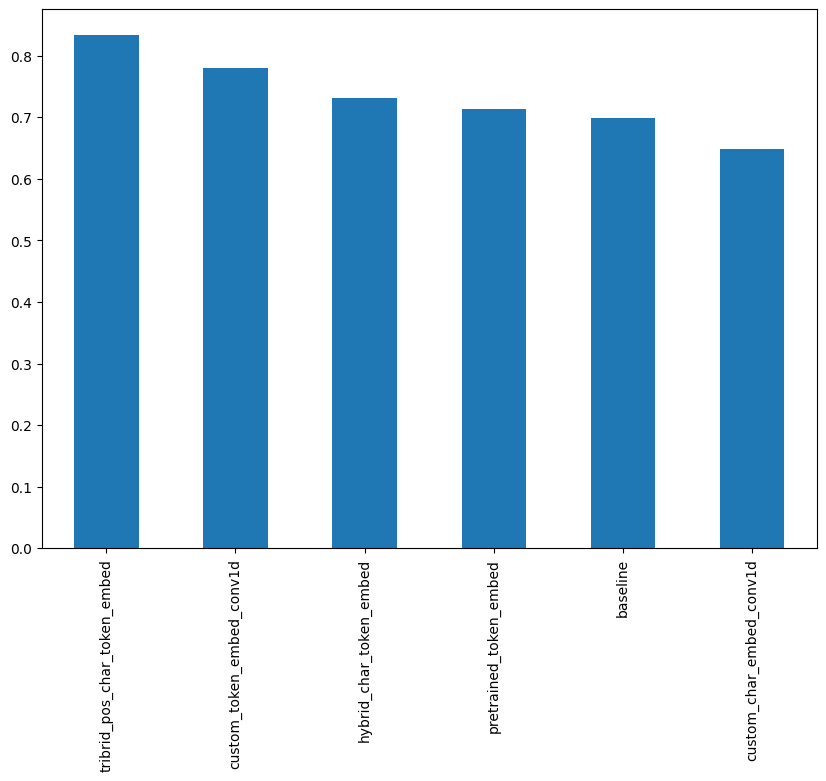

In [123]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

In [124]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [126]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 24s 26ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [127]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 84.94773519163763,
 'precision': 0.8506787095628426,
 'recall': 0.8494773519163763,
 'f1': 0.8464873909313709}

In [128]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 15.7 s, sys: 806 ms, total: 16.6 s
Wall time: 16.4 s


['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 '

In [129]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.340265,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.536902,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.838335,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.827625,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.789321,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.884426,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.600542,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.648189,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.650746,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.665674,True


In [130]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
19223,METHODS,"of the @ dogs receiving placebo , @ ( @ % ) vo...",7,10,RESULTS,0.949026,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.947631,False
22736,OBJECTIVE,"the national institute of oncology , budapest ...",4,20,METHODS,0.939247,False
20427,OBJECTIVE,the national institute of neurological disorde...,1,18,BACKGROUND,0.927777,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.927184,False
...,...,...,...,...,...,...,...
27182,METHODS,ninety patients were enrolled .,4,8,RESULTS,0.855938,False
21186,METHODS,mean distraction rates were similar between gr...,8,17,RESULTS,0.855876,False
19426,RESULTS,"the main outcomes were lifetime costs , qualit...",4,12,METHODS,0.855255,False
25382,METHODS,"at this time , an as@ response was achieved by...",5,7,RESULTS,0.854919,False


In [131]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: METHODS, Pred: RESULTS, Prob: 0.9490258097648621, Line number: 7, Total lines: 10

Text:
of the @ dogs receiving placebo , @ ( @ % ) vomited and @ ( @ % ) developed signs of nausea ; overall , @ of @ ( @ % ) dogs in the placebo treatment group vomited or developed signs of nausea .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9476310014724731, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: OBJECTIVE, Pred: METHODS, Prob: 0.9392474889755249, Line number: 4, Total lines: 20

Text:
the national institute of oncology , budapest conducted a single centre randomized clinical study .

-----

Target: OBJECTIVE, Pred: BACKGROUND, Prob: 0.9277769923210144, Line number: 1, Total lines: 18

Text:
the national institute of neurological disorders and stroke exploratory trials in parkinson disease program was established to promote discovery of potential therapies .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9271842837333679, Line number: 

In [132]:

import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-02-24 17:14:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-02-24 17:14:45 (90.5 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [133]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [134]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [135]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines


[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [136]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [138]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [139]:

# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [141]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step
CPU times: user 3.09 s, sys: 68.4 ms, total: 3.16 s
Wall time: 3.54 s


array([[0.40966064, 0.10150336, 0.0592407 , 0.37632677, 0.05326856],
       [0.12221215, 0.04257365, 0.6395669 , 0.12550288, 0.07014446],
       [0.05971145, 0.02837674, 0.7813849 , 0.0634302 , 0.06709667],
       [0.10669874, 0.19132487, 0.5221027 , 0.07170605, 0.10816757],
       [0.06952166, 0.12572879, 0.22980085, 0.05099934, 0.5239494 ],
       [0.03632959, 0.07012617, 0.56956285, 0.03921237, 0.28476903],
       [0.02509941, 0.11548658, 0.06421211, 0.02612287, 0.769079  ],
       [0.01596976, 0.08247967, 0.07143232, 0.02591252, 0.8042057 ]],
      dtype=float32)

In [142]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 2, 4, 4])>

In [143]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [144]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

BACKGROUND: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
